<a href="https://colab.research.google.com/github/nickwan/speed_dating/blob/master/speed_dating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speed dating LULW 

There's a lot of features to play with so I have no idea what I'm really trying to do here. But the last time this happened, we invented advanced bull riding analytics. so...

In [84]:
!pip install lightgbm --install-option=--gpu
!pip install shap

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 686kB 4.5MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
y
    Running setup.py install for lightgbm ... done


In [81]:
from tqdm.notebook import tqdm
import warnings
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  
from wordcloud import WordCloud
import shap

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from scipy.stats import pearsonr, spearmanr
shap.initjs()

In [3]:
project_dir = 'drive/My Drive/speed-dating-data'
fns = [f"{project_dir}/data/{x}" for x in os.listdir(f"{project_dir}/data") if x.endswith('.csv')]
df = pd.read_csv(fns[0],encoding='latin_1')
df['income'] = df['income'].str.replace(',','').astype(float).fillna(-1)
df.shape

(8378, 195)

## Variables 

col | desc   
--- | ---  
iid | unique subject number   
pid | partner's unique subject number  

# Different imbalanced data approaches
There are four ways I show below: 
1. No treatment for imbalanced data 
2. Upsample the minority target weight (currently, ~4:1 for no match:match; weight each match row by 4)  
3. Downsample the majority target weight 
4. Equivalent target proportions in each fold  


In [4]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [5]:
model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()
model_data.shape

(6578, 15)

In [6]:
model_data['match'].mean()

0.16509577379142595

In [7]:
model_feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
       'attr1_1_p', 'sinc1_1_p', 'intel1_1_p', 'fun1_1_p',
       'amb1_1_p', 'shar1_1_p']

target = 'match'       

In [8]:
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

(6578, 16)

loss: 0.4468 (0.448) 
acc: 0.8349 (0.8349)


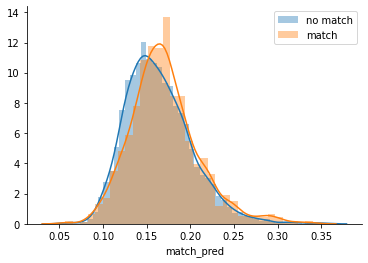

In [9]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [10]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  for _ in range(4):
    train_data = train_data.append(train_data.loc[train_data['match']==1])

  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6578, 16)

loss: 1.2209 (0.448) 
acc: 0.1651 (0.8349)


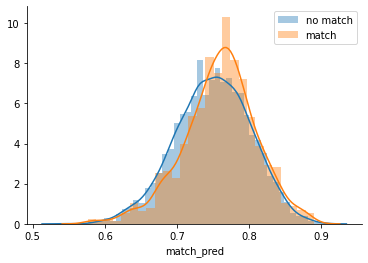

In [11]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [12]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  _train_data = train_data.loc[train_data['match']==0].sample(train_data.loc[train_data['match']==1].shape[0])
  train_data = train_data.loc[train_data['match']==1].append(_train_data)

  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6578, 16)

loss: 0.6907 (0.448) 
acc: 0.5452 (0.8349)


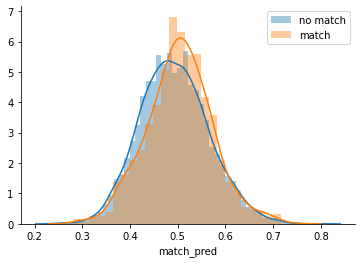

In [13]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [14]:
matched_samples = 22 
not_matched_samples = 110
x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

In [15]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6578, 17)

loss: 0.4447 (0.448) 
acc: 0.8349 (0.8349)


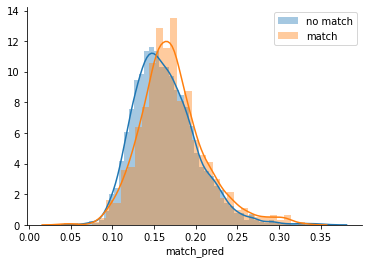

In [16]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

# Add more features 
We'll use the ratings of the partners from the target individual as features. So like, if I was rating "you", I would rate you on the 6 different features of attraction (attractiveness, sincerity, intelligence, fun, ambitious, and shared interests) and you would also rate me. 

However, some folks did not rate people on all of these features. So we'll predict the ratings for the missing values using the other attraction features plus the "like" scale (how much did you like the person). 

In [17]:
model_data = df.loc[:,['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like']].copy()
model_data = model_data.dropna(how='all')
model_data.shape

(8192, 7)

Validation of the features seem to be pretty good. Generally, $RMSE = 1.4$ and $R^2 = 0.42$, which is pretty good for a linear model with zero regularization!  

In [18]:
target = 'like'
model_feats = [x for x in model_data.columns.values if x != target]
target_data = model_data.loc[model_data[target].isnull()].copy()
_model_data = model_data.loc[model_data[target].notnull()].copy().fillna(-1)

df_pred = pd.DataFrame()
kf = KFold(10, shuffle=True)
for train_idx, test_idx in kf.split(_model_data):
  train_data = _model_data.iloc[train_idx]
  test_data = _model_data.iloc[test_idx]

  model = LinearRegression()
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)

  df_pred = df_pred.append(test_data)

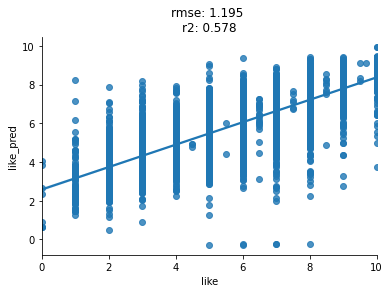

In [19]:
rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_pred"])[0]**2

sns.regplot(target,f'{target}_pred',data=df_pred)
plt.title(f"""rmse: {round(rmse, 3)} \nr2: {round(r2, 3)}""")
sns.despine()
plt.show()

In [20]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)

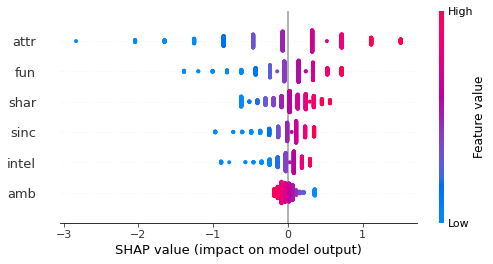

In [21]:
shap.summary_plot(shap_values, shap_data)

In [22]:
shap.initjs()
ind = np.random.choice(range(test_data.shape[0]))
print(f"""actual {target}: {test_data.loc[:,f"{target}"].values[ind]}""")
shap.force_plot(
    explainer.expected_value, 
    shap_values[ind,:], 
    test_data.loc[:,model_feats].values[ind,:], 
    feature_names=model_feats
)


actual like: 8.0


**do the damn thing**

In [23]:
model_data

,attr,sinc,intel,fun,amb,shar,like
0,6.0,9.0,7.0,7.0,6.0,5.0,7.0
1,7.0,8.0,7.0,8.0,5.0,6.0,7.0
2,5.0,8.0,9.0,8.0,5.0,7.0,7.0
3,7.0,6.0,8.0,7.0,6.0,8.0,7.0
4,5.0,6.0,7.0,7.0,6.0,6.0,6.0
...,...,...,...,...,...,...,...
8373,3.0,5.0,5.0,5.0,NaN,NaN,2.0
8374,4.0,6.0,8.0,4.0,4.0,NaN,4.0
8375,4.0,7.0,8.0,8.0,8.0,NaN,6.0
8376,4.0,6.0,5.0,4.0,NaN,5.0,5.0


In [24]:
for target in model_data.columns.values:
  model_feats = [x for x in model_data.columns.values if x != target]
  target_data = model_data.loc[model_data[target].isnull()].copy().fillna(-1)
  _model_data = model_data.loc[model_data[target].notnull()].copy().fillna(-1)
  model = LinearRegression()
  model.fit(_model_data.loc[:,model_feats], _model_data.loc[:,target])
  model_data[target] = model_data[target].fillna(pd.Series(model.predict(target_data.loc[:,model_feats]), index=target_data.index))

# replace that shit in the master df
df.loc[:,model_data.columns.values] = model_data

In [25]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()

_x = df.loc[:,['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like']]
_y = (df
      .loc[:,['iid','pid','attr', 
              'sinc', 'intel', 'fun', 
              'amb', 'shar', 'like']]
      .rename(columns={'iid':'pid', 'pid':'iid'}))

_x =_x.merge(_y, on=['iid','pid'], suffixes=('','_p'))
model_data = model_data.merge(_x).dropna()
model_feats = [x for x in model_data.columns.values if x not in ['iid', 'pid', target]] 
model_data.shape

(6370, 29)

## Using no target balancing for training

In [26]:
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6370, 30)

loss: 0.3441 (0.4567) 
acc: 0.848 (0.8295)


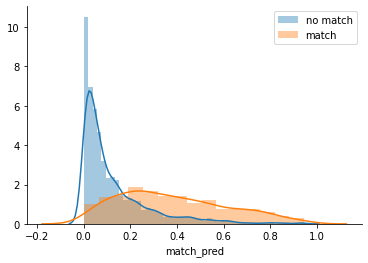

In [27]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

## Use downsampling 

In [28]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  _train_data = train_data.loc[train_data['match']==0].sample(train_data.loc[train_data['match']==1].shape[0])
  train_data = train_data.loc[train_data['match']==1].append(_train_data)

  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6370, 30)

loss: 0.5013 (0.4567) 
acc: 0.7581 (0.8295)


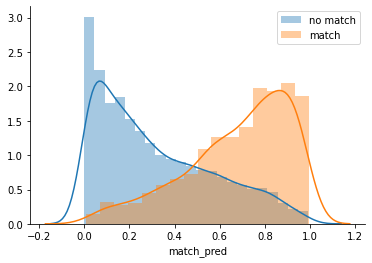

In [29]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

## Using equivalent proportions of targets in each fold

In [30]:
matched_samples = 22 
not_matched_samples = 110
x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

In [31]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6370, 31)

loss: 0.3408 (0.4567) 
acc: 0.8496 (0.8295)


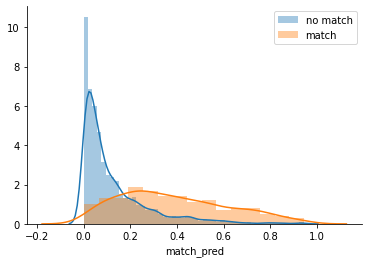

In [32]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [33]:
test_data = model_data.loc[:,model_feats+[target]].sample(1500)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats+[target]]

In [34]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)

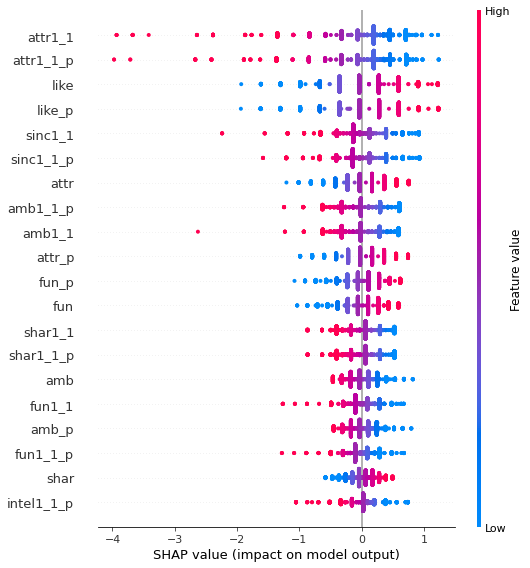

In [35]:
shap.summary_plot(shap_values, shap_data)

In [36]:
shap.initjs()
ind = np.random.choice(range(test_data.shape[0]))
print(f"""actual {target}: {test_data.loc[:,f"{target}"].values[ind]}""")
shap.force_plot(
    explainer.expected_value, 
    shap_values[ind,:], 
    test_data.loc[:,model_feats].values[ind,:], 
    feature_names=model_feats
)


actual match: 0


# Add even more features? 

Using hobbies as a feature helped with log loss but didn't improve accuracy  

In [37]:
interests = ['sports', 'tvsports', 'exercise', 'dining', 'museums',
             'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
             'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
target='like_p'
model_data = df.loc[:,['iid','pid']+interests].merge(df.loc[:,['iid','pid','like']].rename(columns={'iid':'pid','pid':'iid','like':'like_p'})).dropna()
model_data.shape

(8110, 20)

In [38]:
kf = KFold(50, shuffle=True)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = LinearRegression()
  model.fit(train_data.loc[:,interests], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,interests]), index=test_data.index)
  df_pred = df_pred.append(test_data)

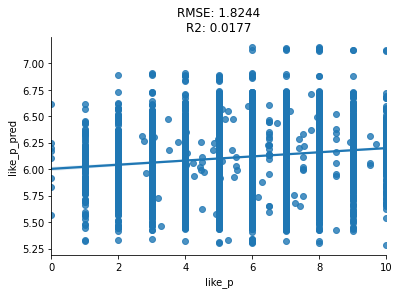

In [39]:
rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_pred"])[0]**2

sns.regplot(target, f"{target}_pred", data=df_pred)
plt.title(f"""RMSE: {round(rmse,4)}\nR2: {round(r2,4)}""")
sns.despine()
plt.show()

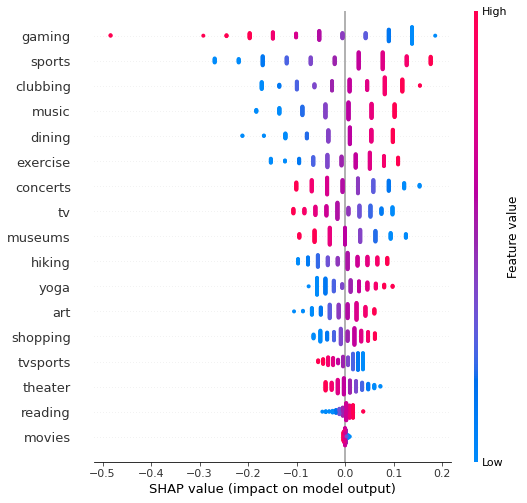

In [40]:
shap_data = test_data.loc[:,interests]
explainer = shap.LinearExplainer(model, train_data.loc[:,interests]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [41]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()

_x = df.loc[:,['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
               'sports', 'tvsports', 'exercise', 'dining', 'museums',
               'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
               'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']]
_y = (df
      .loc[:,['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
              'sports', 'tvsports', 'exercise', 'dining', 'museums',
              'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
              'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']]
      .rename(columns={'iid':'pid', 'pid':'iid'}))

_x =_x.merge(_y, on=['iid','pid'], suffixes=('','_p'))
model_data = model_data.merge(_x).dropna()
model_feats = [x for x in model_data.columns.values if x not in ['iid', 'pid', target]] 
model_data.shape

(6370, 63)

In [42]:
matched_samples = 22 
not_matched_samples = 110
x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

In [43]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6370, 65)

loss: 0.3383 (0.4567) 
acc: 0.8504 (0.8295)


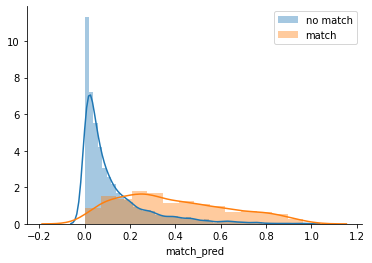

In [44]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

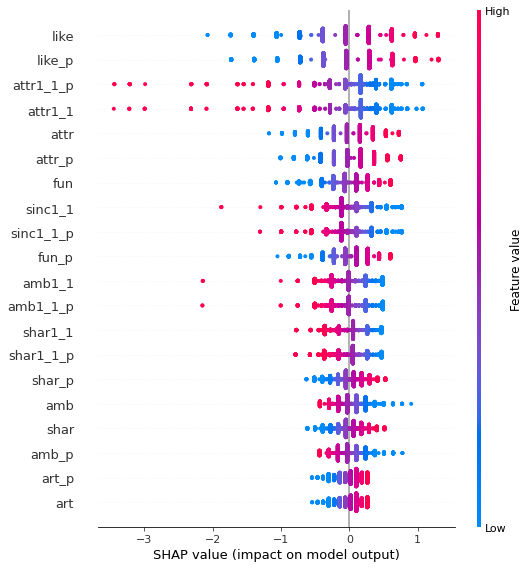

In [45]:
test_data = model_data.loc[:,model_feats+[target]].sample(1500)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats+[target]]
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

personal assessment doesn't help with strong model features but it slightly improves model accuracy and loss 

In [46]:
model_feats = ['attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1']
target = 'like_p'
model_data = df.loc[:,['iid','pid']+model_feats].merge(df.loc[:,['iid','pid','like']].rename(columns={'iid':'pid','pid':'iid','like':'like_p'})).dropna()
model_data.shape

(8085, 8)

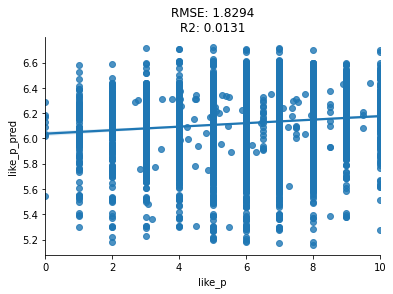

In [47]:
kf = KFold(50, shuffle=True)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = LinearRegression()
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)

rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_pred"])[0]**2

sns.regplot(target, f"{target}_pred", data=df_pred)
plt.title(f"""RMSE: {round(rmse,4)}\nR2: {round(r2,4)}""")
sns.despine()
plt.show()  

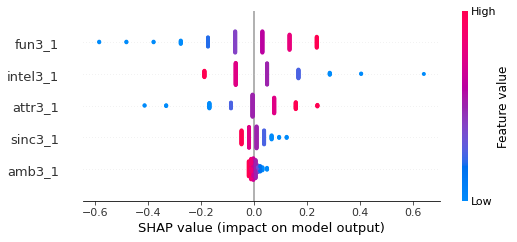

In [48]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [49]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()

_x = df.loc[:,['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
               'sports', 'tvsports', 'exercise', 'dining', 'museums',
               'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
               'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 
               'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1']]
_y = (df
      .loc[:,['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
              'sports', 'tvsports', 'exercise', 'dining', 'museums',
              'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
              'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 
              'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1']]
      .rename(columns={'iid':'pid', 'pid':'iid'}))

_x =_x.merge(_y, on=['iid','pid'], suffixes=('','_p'))
model_data = model_data.merge(_x).dropna()
model_feats = [x for x in model_data.columns.values if x not in ['iid', 'pid', target]] 

data_per_fold = int(np.ceil(model_data['match'].shape[0]/50))
targets_per_fold = int(np.ceil(data_per_fold * model_data['match'].mean()))
non_targets_per_fold = int(np.ceil(data_per_fold * (1-model_data['match'].mean())))

matched_samples = targets_per_fold 
not_matched_samples = non_targets_per_fold

x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6320, 75)

loss: 0.335 (0.4517) 
acc: 0.8552 (0.8326)


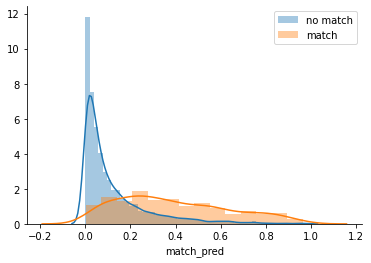

In [50]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

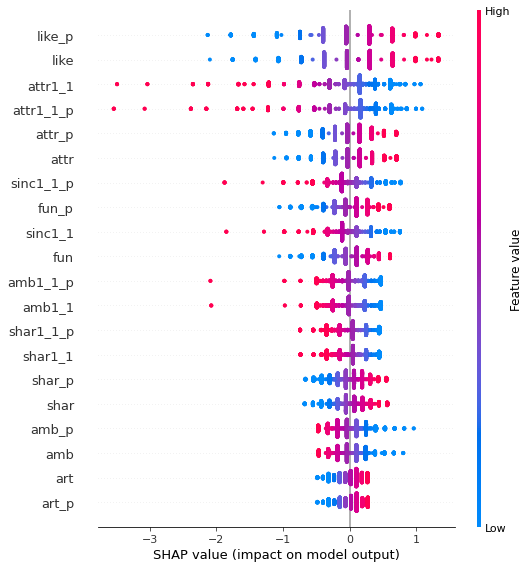

In [51]:
test_data = model_data.loc[:,model_feats+[target]].sample(1500)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats+[target]]
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

i hate that i'm doing income i hate it but we're gonna do it. 
note: income made the model worse!!  

expectations of how happy someone will be with the people they meet in the session also do not improve the model performance. 

iid estimated probability of the other person liking them improved the loss of the model. 

age is an important estimator for accuracy and loss, but not necessarily a great independent feature.  

self reported importance of race and religion are non-factors.  

I think we've done enough with scale variables up to this point. Our feature set has no categorical variables yet, so that will be the next thing to investigate. However, I have strong doubts the linear model will be able to handle the categorical variables well. So it is more than likely we'll want to use a new model that can handle categorical variables better. But we will try with linear models for now, so long as the model accuracy and loss are improving. 

In [52]:
model_feats = ['imprace', 'imprelig']
target = 'like_p'
model_data = df.loc[:,['iid','pid']+model_feats].merge(df.loc[:,['iid','pid','like']].rename(columns={'iid':'pid','pid':'iid','like':'like_p'})).dropna()
model_data.shape

(8110, 5)

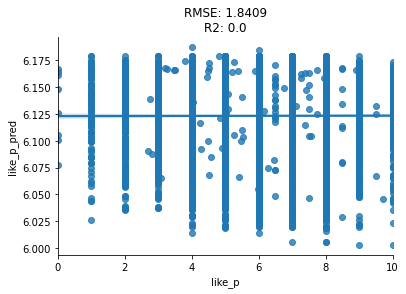

In [53]:
kf = KFold(50, shuffle=True)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = LinearRegression()
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)

rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_pred"])[0]**2

sns.regplot(target, f"{target}_pred", data=df_pred)
plt.title(f"""RMSE: {round(rmse,4)}\nR2: {round(r2,4)}""")
sns.despine()
plt.show()  

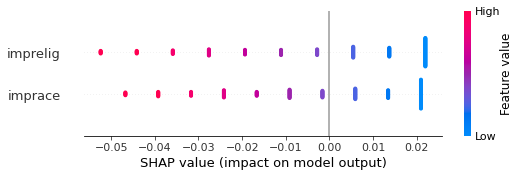

In [54]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [55]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
merge_features = ['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
               'sports', 'tvsports', 'exercise', 'dining', 'museums',
               'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
               'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 
               'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'prob', 
               'age', 'imprace', 'imprelig']

model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()

_x = df.loc[:,merge_features]
_y = (df.loc[:,merge_features].rename(columns={'iid':'pid', 'pid':'iid'}))

_x =_x.merge(_y, on=['iid','pid'], suffixes=('','_p'))
model_data = model_data.merge(_x).dropna()
model_data['age_dist'] = model_data['age'].sub(model_data['age_p']).abs()
model_feats = [x for x in model_data.columns.values if x not in ['iid', 'pid', target, 'age', 'age_p']] 

data_per_fold = int(np.ceil(model_data['match'].shape[0]/50))
targets_per_fold = int(np.ceil(data_per_fold * model_data['match'].mean()))
non_targets_per_fold = int(np.ceil(data_per_fold * (1-model_data['match'].mean())))

matched_samples = targets_per_fold 
not_matched_samples = non_targets_per_fold

x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6124, 84)

loss: 0.3274 (0.4546) 
acc: 0.8534 (0.8308)


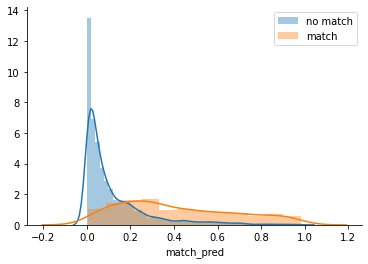

In [56]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

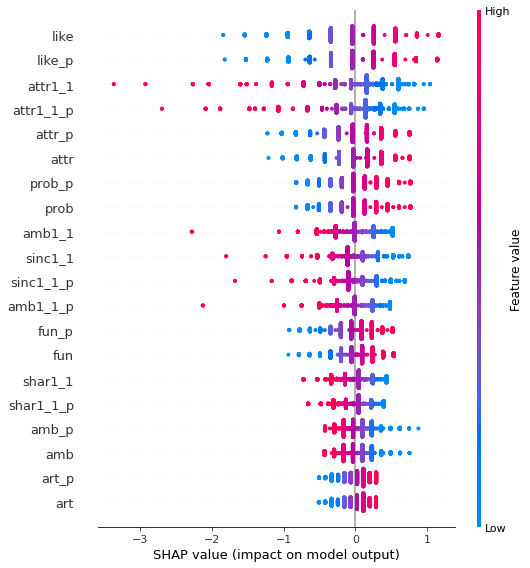

In [57]:
test_data = model_data.loc[:,model_feats+[target]].sample(1500)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats+[target]]
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

# Okay let's try the categorical variables 
I don't think the linear models will really take the categorical variables well but we'll start there and then probably move into a random forest or GBM 

In [58]:
model_feats = ['gender', 'field_cd','race','career_c']
target = 'like_p'
model_data = df.loc[:,['iid','pid']+model_feats].merge(df.loc[:,['iid','pid','like']].rename(columns={'iid':'pid','pid':'iid','like':'like_p'})).dropna()
model_data.shape

(8051, 7)

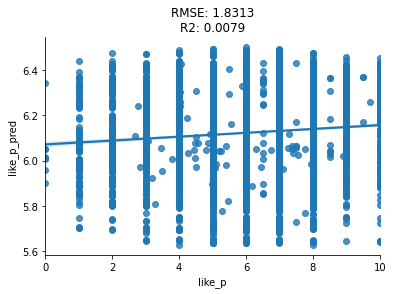

In [59]:
kf = KFold(50, shuffle=True)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = LinearRegression()
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)

rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_pred"])[0]**2

sns.regplot(target, f"{target}_pred", data=df_pred)
plt.title(f"""RMSE: {round(rmse,4)}\nR2: {round(r2,4)}""")
sns.despine()
plt.show()  

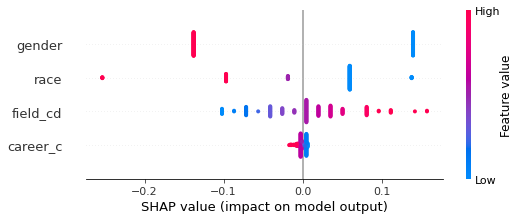

In [60]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [61]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
merge_features = ['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
               'sports', 'tvsports', 'exercise', 'dining', 'museums',
               'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
               'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 
               'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'prob', 
               'age', 'imprace', 'imprelig', 'gender', 'field_cd', 'race',
               'career_c']

model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()

_x = df.loc[:,merge_features]
_y = (df.loc[:,merge_features].rename(columns={'iid':'pid', 'pid':'iid'}))

_x =_x.merge(_y, on=['iid','pid'], suffixes=('','_p'))
model_data = model_data.merge(_x).dropna()
model_data['age_dist'] = model_data['age'].sub(model_data['age_p']).abs()
model_feats = [x for x in model_data.columns.values if x not in ['iid', 'pid', target, 'age', 'age_p']] 

data_per_fold = int(np.ceil(model_data['match'].shape[0]/50))
targets_per_fold = int(np.ceil(data_per_fold * model_data['match'].mean()))
non_targets_per_fold = int(np.ceil(data_per_fold * (1-model_data['match'].mean())))

matched_samples = targets_per_fold 
not_matched_samples = non_targets_per_fold

x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6022, 92)

loss: 0.3283 (0.456) 
acc: 0.85 (0.83)


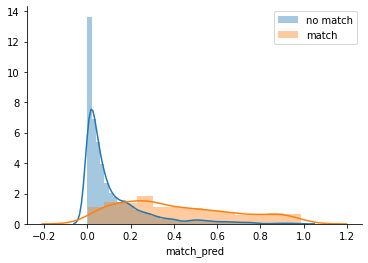

In [62]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

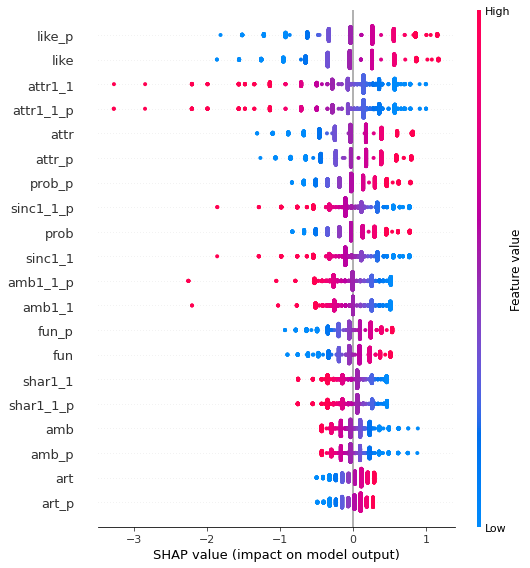

In [63]:
test_data = model_data.loc[:,model_feats+[target]].sample(1500)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats+[target]]
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

We can see linear modeling doesn't really treat the categorical variables with any weight, whereas the research (see: https://faculty.chicagobooth.edu/emir.kamenica/documents/racialpreferences.pdf) indicates there definitely should be correlations and preferences in these categorical variables. So we will change the model type away from linear modeling towards non-linear modeling. We'll start with random forest. 

In [64]:
model_feats = ['gender', 'field_cd','race','career_c']
target = 'like_p'
model_data = df.loc[:,['iid','pid']+model_feats].merge(df.loc[:,['iid','pid','like']].rename(columns={'iid':'pid','pid':'iid','like':'like_p'})).dropna()
model_data.shape

(8051, 7)

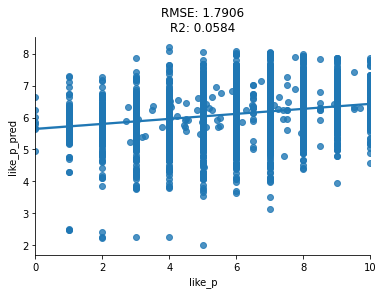

In [65]:
kf = KFold(50, shuffle=True)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = RandomForestRegressor()
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)

rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_pred"])[0]**2

sns.regplot(target, f"{target}_pred", data=df_pred)
plt.title(f"""RMSE: {round(rmse,4)}\nR2: {round(r2,4)}""")
sns.despine()
plt.show()  

 99%|===================| 160/161 [02:25<00:00]       

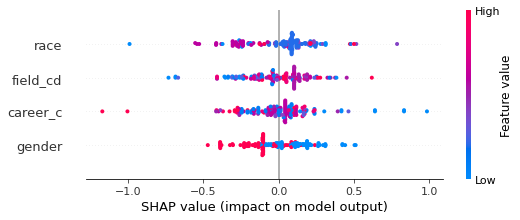

In [66]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [67]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
merge_features = ['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
               'sports', 'tvsports', 'exercise', 'dining', 'museums',
               'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
               'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 
               'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'prob', 
               'age', 'imprace', 'imprelig', 'gender', 'field_cd', 'race',
               'career_c']

model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()

_x = df.loc[:,merge_features]
_y = (df.loc[:,merge_features].rename(columns={'iid':'pid', 'pid':'iid'}))

_x =_x.merge(_y, on=['iid','pid'], suffixes=('','_p'))
model_data = model_data.merge(_x).dropna()
model_data['age_dist'] = model_data['age'].sub(model_data['age_p']).abs()
model_feats = [x for x in model_data.columns.values if x not in ['iid', 'pid', target, 'age', 'age_p']] 

data_per_fold = int(np.ceil(model_data['match'].shape[0]/50))
targets_per_fold = int(np.ceil(data_per_fold * model_data['match'].mean()))
non_targets_per_fold = int(np.ceil(data_per_fold * (1-model_data['match'].mean())))

matched_samples = targets_per_fold 
not_matched_samples = non_targets_per_fold

x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = RandomForestClassifier()
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6022, 92)

loss: 0.33 (0.456) 
acc: 0.8645 (0.83)


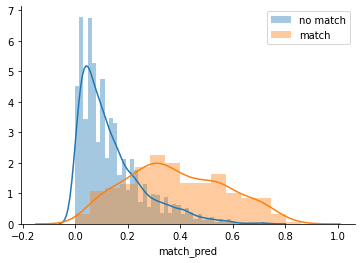

In [68]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [74]:
test_data = model_data.loc[:,model_feats+[target]].sample(200)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats+[target]].sample(500)
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)

 98%|===================| 394/400 [00:58<00:00]       

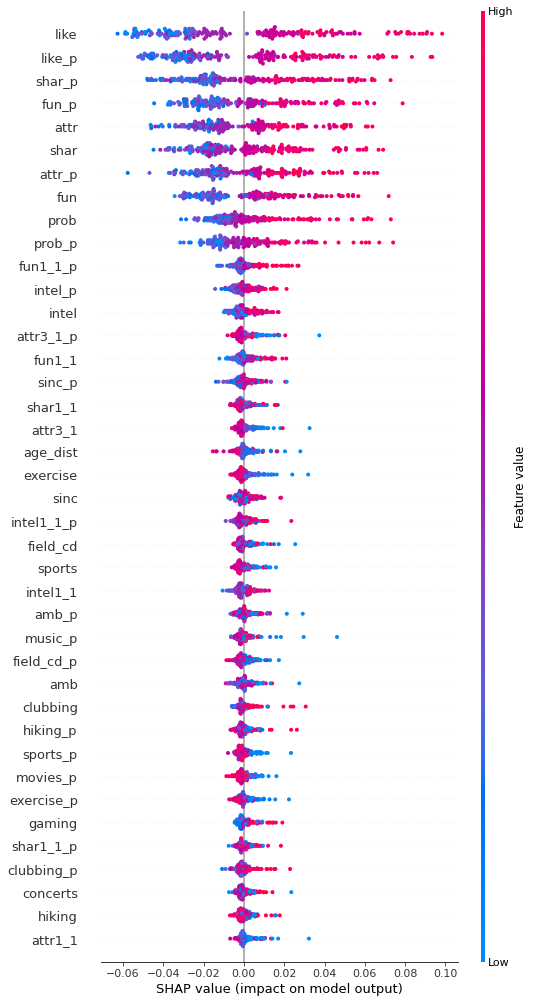

In [76]:
shap.summary_plot(shap_values[1], shap_data, max_display=40)

The random forest model was pretty good at improving target accuracy, mainly by being able to utilize categorical variables better than the linear modeling techniques. Let's try a little more high-powered modeling with a GBM

In [88]:
model_feats = ['gender', 'field_cd','race','career_c']
target = 'like_p'
model_data = df.loc[:,['iid','pid']+model_feats].merge(df.loc[:,['iid','pid','like']].rename(columns={'iid':'pid','pid':'iid','like':'like_p'})).dropna()
model_data.shape

(8051, 7)

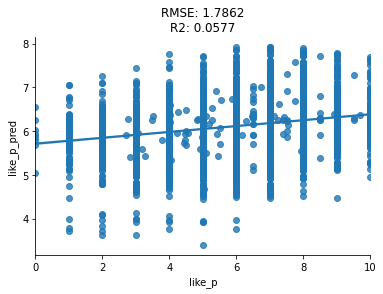

In [92]:
p = dict(
    device_type='cpu',
    learning_rate = 0.01     
    )

kf = KFold(50, shuffle=True)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  train_data = lgb.Dataset(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data = model_data.iloc[test_idx]

  model = lgb.train(p, train_data, num_boost_round=1000)
  # model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)

rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_pred"])[0]**2

sns.regplot(target, f"{target}_pred", data=df_pred)
plt.title(f"""RMSE: {round(rmse,4)}\nR2: {round(r2,4)}""")
sns.despine()
plt.show()  

In [98]:
p = dict(
    device_type='cpu',
    learning_rate = 0.01, 
    objective = 'binary'     
    )

target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
merge_features = ['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
               'sports', 'tvsports', 'exercise', 'dining', 'museums',
               'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
               'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 
               'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'prob', 
               'age', 'imprace', 'imprelig', 'gender', 'field_cd', 'race',
               'career_c']

model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()

_x = df.loc[:,merge_features]
_y = (df.loc[:,merge_features].rename(columns={'iid':'pid', 'pid':'iid'}))

_x =_x.merge(_y, on=['iid','pid'], suffixes=('','_p'))
model_data = model_data.merge(_x).dropna()
model_data['age_dist'] = model_data['age'].sub(model_data['age_p']).abs()
model_feats = [x for x in model_data.columns.values if x not in ['iid', 'pid', target, 'age', 'age_p']] 

data_per_fold = int(np.ceil(model_data['match'].shape[0]/50))
targets_per_fold = int(np.ceil(data_per_fold * model_data['match'].mean()))
non_targets_per_fold = int(np.ceil(data_per_fold * (1-model_data['match'].mean())))

matched_samples = targets_per_fold 
not_matched_samples = non_targets_per_fold

x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  train_data = lgb.Dataset(train_data.loc[:,model_feats], train_data.loc[:,target])  
  test_data = model_data.loc[model_data['block']==block_num] 
  model = lgb.train(p, train_data, num_boost_round=1000)
  # model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6022, 92)

loss: 0.2845 (0.456) 
acc: 0.8751 (0.83)


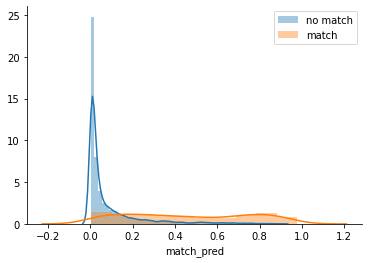

In [99]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [100]:
test_data = model_data.loc[:,model_feats+[target]].sample(200)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats+[target]].sample(500)
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)

 99%|===================| 198/200 [00:46<00:00]       

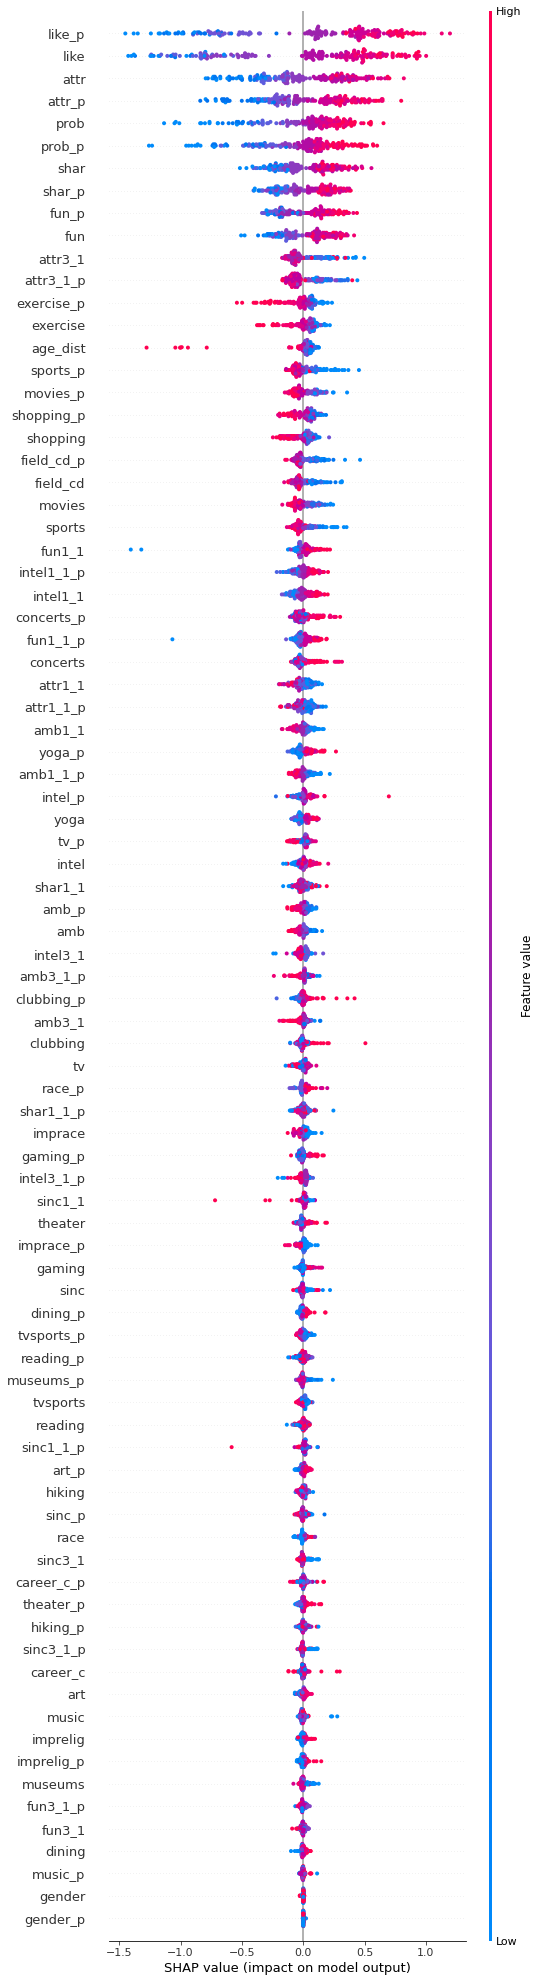

In [103]:
shap.summary_plot(shap_values, shap_data, max_display=100)

# Takeaways 
Above all, if you like the "full package" of someone and they also have an equivalent like towards you, that is the most important thing in matching with someone. Other important features include if you both find each other attractive, if you both have a good "vibe" or sense that both of you want to see each other again, if you both have shared interests, and if you both find each other fun.  

Other features (like race, religion, and hobbies) did not play as strong of a factor on whether two people would match with each other. However, based on post-hoc analyses, it seems clear that there is an implicit effect of race and attractiveness. It would make sense that something like attractiveness is ranked high and race and other factors that play into "attractiveness" are lower in model feature importance because attractiveness is all encompassing -- includes race, any other physical features, and perhaps non-physical features as well (like income, career, age, etc).  

Although tons more research could go into this notebook and dissect all of the interactions in "attractiveness", I find the purpose I set out for (namely, making a more accurate model than chance) was completed. I ended up with a model with stronger accuracy than simply guessing the average response and I was able to explain why the model I build weighted or ranked certain features more important or less important than others. Ultimately, my narrow research interest in this dataset was completed and I am content with my findings. 

I do challenge anyone who finds this notebook to expand on my findings, and perhaps feature-engineer more accurate features that can handle race, income, age, career/field of study, and hobbies/interests in a way that my model fails to handle. 

-nw 8/19/2020 

In [115]:
df.loc[:, ['gender', 'race', 'attr_o']].groupby(['gender', 'race'], as_index=False).mean()

,gender,race,attr_o
0,0,1.0,5.957082
1,0,2.0,6.612685
2,0,3.0,6.829049
3,0,4.0,6.123167
4,0,6.0,6.356846
5,1,1.0,6.202247
6,1,2.0,6.161494
7,1,3.0,6.070039
8,1,4.0,5.210671
9,1,6.0,5.678967


In [110]:
df.loc[:, 'match'].mean()

0.16471711625686322

In [109]:
df.loc[(df['samerace']==0), 'match'].mean()

0.1608060055314105

In [108]:
df.loc[(df['samerace']==1), 'match'].mean()

0.1706875753920386

In [113]:
df.loc[:,'race'].value_counts().div(df.loc[:,'race'].value_counts().sum())

2.0    0.568491
4.0    0.238364
3.0    0.079856
6.0    0.062778
1.0    0.050511
Name: race, dtype: float64

In [107]:
df.loc[df['match']==1,'race'].value_counts().div(df.loc[:,'race'].value_counts())

2.0    0.166702
4.0    0.134712
3.0    0.185241
6.0    0.197318
1.0    0.202381
Name: race, dtype: float64